# AMC + Demodulation Using LSTM Seq2Seq Autoencoder

## Import libraries

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from comms import awgn, make_rrc, modulate, demodulate, pulse_shape

## Functions

In [2]:
def gen_data(num_examples, seq_length, mod_order=4, sps=4, span=10, snr=50, normalize=True):
    '''
    This function produces a num_examples number of pulse shaped M-QAM waveforms, each
    example is made up from seq_length*sps samples.
    '''
    
    # Calculate number of weights based on sps and span, and create an RRC filter
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    # Generate random bits
    ints = np.random.randint(low=0, high=mod_order, size=(num_examples * seq_length))
    
    # Modulate according to mod order
    samples = modulate(ints, M=mod_order)
    
    # Pulse shape / upsample the symbols
    samples_pulse_shaped = pulse_shape(samples, hrrc, sps=sps)
    
    # Add noise. IMPORTANT -> measured=True (keep note of this when eveluating)
    samples_noisy = awgn(samples_pulse_shaped, snr, measured=True)
    
    # Reshape the vectors into a new array of shape [num_examples, seq_length]
    data = samples_noisy.reshape(num_examples,-1)
    labels = ints.reshape(num_examples,-1)
    
    # Optionally normalize the waveform (helps with training)
    if normalize:
        data = (data/np.max(np.abs(data),axis=1)[:,None])
    
    return data, labels

def to_tensors(x,y, onehot=False, gpu=False, batch_first=False, normalize=True, num_classes=None, conv_compatible=False):
    '''
    This function takes the outputs from gen_data and does the necessary formatting
    to make the data compatible with torch nn layers.
    '''
    
    # Split complex x into real/imaginary along 3rd axis
    # 2d -> 3d tensor
    x = torch.FloatTensor(np.stack((x.real, x.imag), axis=2))
    
    # conv1d expects (N, channel_in, length) shape
    if conv_compatible:
        x = x.permute((0,2,1))
    
    # One hot encoding if doing MSE/CrossEntropy
    # Otherwise NLLLoss will take the LongTensor
    if onehot:
        y = torch.LongTensor(y)
        if num_classes:
            y = F.one_hot(y, num_classes=num_classes)
        else:
            y = F.one_hot(y, num_classes=len(np.unique(y)))
    else:
        y = torch.LongTensor(y)
        
    # LSTM expects (seq, batch, feats) input shape
    if not batch_first:
        x = x.permute((1,0,2))
        if onehot:
            y = y.permute((1,0,2))
        else:
            y = y.unsqueeze(2).permute((1,0,2))
    
    # Move to cuda device memory if gpu is used
    if gpu:
        x = x.cuda()
        y = y.cuda()
    
    return x,y

## Architecture

In [26]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu', dropout=0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout)

    def forward(self, input):
        
        output, hidden = self.rnn(input)
        
        return output, hidden
    
    def initHidden(self, batch_size=32, device='cpu'):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
    

class EncoderConvRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu', num_filters=16, dropout=0):
        super(EncoderConvRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.conv1 = nn.Conv1d(2, num_filters, 9, padding=4)
        self.conv2 = nn.Conv1d(num_filters, 8, 9)
        self.maxpool = nn.MaxPool1d(2)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = x.permute(0,2,1)
#         x = x.permute(2,0,1)
        
        output, hidden = self.rnn(x)
        
        return output, hidden
    
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu', dropout=0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        rnn_output, hidden = self.rnn(input, hidden)
        
        rnn_output = self.dropout(rnn_output)
        y = self.out(rnn_output)
        
        return y, hidden

## Training

Define the training and validation functions for one epoch.

In [36]:
def gen_dataset(data_config, train_config, conv_compatible=False):
    
    # if multiple SNR
    if type(data_config['snr']) == np.ndarray:
        datas, labels = [], []
        for sn in data_config['snr']:
            x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'],
                              data_config['seq_length'],
                              sps=data_config['sps'],
                              mod_order=2,
                              snr=sn)
            
            x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'],
                              data_config['seq_length'],
                              sps=data_config['sps'],
                              mod_order=4,
                              snr=sn)
            
            y_qpsk += 2
            
            datas.append(x_bpsk)
            datas.append(x_qpsk)
            labels.append(y_bpsk)
            labels.append(y_qpsk)

        x = np.concatenate((datas))
        y = np.concatenate((labels))
    
    # if single SNR
    else:
        x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=2, sps=data_config['sps'], 
                                  snr=data_config['snr'])

        x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=4, sps=data_config['sps'], 
                                  snr=data_config['snr'])
        y_qpsk += 2
        x = np.concatenate((x_bpsk, x_qpsk))
        y = np.concatenate((y_bpsk, y_qpsk))

    x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True, num_classes=6, conv_compatible=conv_compatible)

    train_dataset = torch.utils.data.TensorDataset(x, y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    
    return train_dataloader

def train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, tf_ratio=0, gpu=True, num_classes=6, conv=False):
    
    batch_size = x_train.shape[0]
    seq_length = y_train.shape[1]
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # format to (seq x batch x feats) format
    if not conv:
        x_train = x_train.permute((1,0,2))
    y_train = y_train.permute((1,0,2))

    loss = 0

    _, encoder_hidden = encoder(x_train)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,batch_size,num_classes))
        
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(seq_length):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(y.squeeze(), y_train[i].argmax(axis=1)) # cross entropy

        teacher_forcing = np.random.random() < tf_ratio
        if teacher_forcing:
            decoder_input = y_train[i].float().unsqueeze(0)
        else:
            decoder_input = y

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/y_train.shape[0]

def val_step(x_val, y_val, encoder, decoder, criterion, gpu=True, num_classes=6, conv=False):
    
    batch_size = x_val.shape[0]
    
    if not conv:
        x_val = x_val.permute((1,0,2))
    y_val = y_val.permute((1,0,2))

    loss = 0

    _, encoder_hidden = encoder(x_val)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,batch_size,num_classes))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_val.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
#         loss += criterion(y.squeeze(), y_val[i].squeeze().float()) #mse
        loss += criterion(y.squeeze(), y_val[i].argmax(axis=1)) # cross-entropy
        decoder_input = y
    
    return loss.item()/y_val.shape[0]

def inference(x_test, encoder, decoder, num_classes=6, seq_length=5, batch_size=32):
        
#     encoder_hidden = encoder.initHidden()

#     encoder_hidden = encoder.initHidden(batch_size=batch_size)
    _, encoder_hidden = encoder(x_test)

    decoder_hidden = encoder_hidden

    decoder_outputs = torch.zeros((seq_length,batch_size,num_classes))
    decoder_input = torch.zeros((1,batch_size,num_classes))
    
    for i in range(seq_length):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        decoder_outputs[i] = y
        decoder_input = y
        
    return decoder_outputs

def eval_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, 
                  sps=4, num_classes=6, batch_size=32, conv=False):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x, y, batch_first=True, conv_compatible=conv)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            # x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes, seq_length=seq_length)

            corrects += torch.sum(y_hat.argmax(axis=2) == y.squeeze())

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

In [5]:
def gen_validation_dataloader(snrs, seq_length, examples_per_snr=32):
    ## bpsk
    datas, labels = [], []
    for snr in snrs:
        x_bpsk, y_bpsk = gen_data(examples_per_snr, seq_length, mod_order=2, sps=4, snr=snr)
        datas.append(x_bpsk)
        labels.append(y_bpsk)
        
    x_bpsk = np.concatenate((datas))
    y_bpsk = np.concatenate((labels))

    x_val_bpsk, y_val_bpsk = to_tensors(x_bpsk, y_bpsk, batch_first=True, gpu=True, onehot=True, num_classes=6,conv_compatible=True)
    val_dataloader_bpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_bpsk, y_val_bpsk), batch_size=32, shuffle=True)

    ## qpsk
    datas, labels = [], []
    for snr in snrs:
        x_qpsk, y_qpsk = gen_data(examples_per_snr, seq_length, mod_order=4, sps=4, snr=snr)
        datas.append(x_qpsk)
        labels.append(y_qpsk)
        
    x_qpsk = np.concatenate((datas))
    y_qpsk = np.concatenate((labels))
    y_qpsk += 2

    x_val_qpsk, y_val_qpsk = to_tensors(x_qpsk, y_qpsk, batch_first=True, gpu=True, onehot=True, num_classes=6, conv_compatible=True)
    val_dataloader_qpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_qpsk, y_val_qpsk), batch_size=32, shuffle=True)

    return val_dataloader_bpsk, val_dataloader_qpsk

## Train and evaluate

In [19]:
data_config = {'snr': np.arange(-5,21,5),
               'num_examples_bpsk': 2048,
               'num_examples_qpsk': 2048,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

train_config = {'num_epochs': 250,
                'batch_size': 64,
                'learning_rate': 3e-4,
                'weight_decay': 0.0001,
                'device': 'cuda',
                'tf_ratio': 0}

model_config = {'hidden_size': 16,
                'num_layers': 2,
                'input_size': 8,
                'output_size': 6}

In [44]:
seq_lengths = [5]#[10, 15, 20]
model_configs = [(128,2)]#[(16,2), (128,2)]
gpu = True

for model_config in model_configs:
    for seq_length in seq_lengths:
        print(seq_length)
        data_config['seq_length'] = seq_length
        
        np.random.seed(0)
        train_dataloader = gen_dataset(data_config, train_config, conv_compatible=True)
        val_dataloader_bpsk, val_dataloader_qpsk = gen_validation_dataloader(data_config['snr'], seq_length)

        criterion = nn.CrossEntropyLoss()

        torch.manual_seed(0)
        
        # Create the encoder and decoder models
        encoder = EncoderConvRNN(hidden_size=model_config[0], input_size=8, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
        decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')

        encoder.cuda()
        decoder.cuda()

        # Initialize the optimizers
        encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

        # Define empty lists where loss progress will be stored
        losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

        best_loss = np.inf

        # Training loop
        for epoch in range(train_config['num_epochs']):
            train_loss = 0
            for x_train,y_train in train_dataloader:

                train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, gpu=gpu, conv=True)

            losses.append(train_loss/len(train_dataloader))

            with torch.no_grad():
                val_loss = 0
                for x_val,y_val in val_dataloader_bpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

                val_loss = 0
                for x_val,y_val in val_dataloader_qpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

                val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
                val_losses.append(val_loss)

                if val_loss < best_loss:
                    encoder_weights = encoder.state_dict()
                    decoder_weights = decoder.state_dict()
                    best_loss = val_losses[-1]
                    print(f"{epoch}: Best loss {best_loss}, saving...")

        encoder.load_state_dict(encoder_weights)
        decoder.load_state_dict(decoder_weights)
        
        train_results = {'encoder': encoder_weights,
                        'decoder': decoder_weights,
                        'losses': losses,
                        'val_losses': val_losses,
                        'val_losses_bpsk': val_losses_bpsk,
                        'val_losses_qpsk': val_losses_qpsk}
        
        torch.save(train_results, f"models/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{data_config['seq_length']}_trained_on_2048.pt")

5
0: Best loss 1.1733760277430216, saving...
1: Best loss 1.0727361996968587, saving...
2: Best loss 0.9690527677536012, saving...
3: Best loss 0.9314283967018127, saving...
4: Best loss 0.912697466214498, saving...
5: Best loss 0.8548606117566427, saving...
6: Best loss 0.7449309508005777, saving...
7: Best loss 0.6320814390977224, saving...
8: Best loss 0.5054088900486629, saving...
9: Best loss 0.46798329055309296, saving...
10: Best loss 0.42809632619222004, saving...
11: Best loss 0.3815147082010905, saving...
12: Best loss 0.3346120660503705, saving...
14: Best loss 0.333273317416509, saving...
15: Best loss 0.3080309063196182, saving...
16: Best loss 0.28677943150202434, saving...
17: Best loss 0.27714933951695764, saving...
22: Best loss 0.2632182891170184, saving...
23: Best loss 0.24927527209122974, saving...
24: Best loss 0.234038141866525, saving...
28: Best loss 0.2241744856039683, saving...
30: Best loss 0.21362448334693906, saving...
33: Best loss 0.2109797184665998, sav

### With dropout

In [27]:
seq_lengths = [10, 15, 20]
model_configs = [(128,2)]#[(16,2), (128,2)]
dropouts = [0.25, 0.5]
gpu = True

for dropout in dropouts:
    for model_config in model_configs:
        for seq_length in seq_lengths:
            print(seq_length)
            data_config['seq_length'] = seq_length
            
            np.random.seed(0)
            train_dataloader = gen_dataset(data_config, train_config, conv_compatible=True)
            val_dataloader_bpsk, val_dataloader_qpsk = gen_validation_dataloader(data_config['snr'], seq_length)

            criterion = nn.CrossEntropyLoss()

            torch.manual_seed(0)
            
            # Create the encoder and decoder models
            encoder = EncoderConvRNN(hidden_size=model_config[0], input_size=8, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu', dropout=dropout)
            decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu', dropout=dropout)

            encoder.cuda()
            decoder.cuda()

            # Initialize the optimizers
            encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
            decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

            # Define empty lists where loss progress will be stored
            losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

            best_loss = np.inf

            # Training loop
            for epoch in range(train_config['num_epochs']):
                # Training mode -- enable dropout
                encoder.train()
                decoder.train()
                train_loss = 0
                for x_train,y_train in train_dataloader:

                    train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, gpu=gpu, conv=True)

                losses.append(train_loss/len(train_dataloader))

                with torch.no_grad():
                    # Deactivate dropout layers
                    encoder.eval()
                    decoder.eval()
                    
                    val_loss = 0
                    for x_val,y_val in val_dataloader_bpsk:
                        val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                    val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

                    val_loss = 0
                    for x_val,y_val in val_dataloader_qpsk:
                        val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                    val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

                    val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
                    val_losses.append(val_loss)

                    if val_loss < best_loss:
                        encoder_weights = encoder.state_dict()
                        decoder_weights = decoder.state_dict()
                        best_loss = val_losses[-1]
                        print(f"{epoch}: Best loss {best_loss}, saving...")

            encoder.load_state_dict(encoder_weights)
            decoder.load_state_dict(decoder_weights)
            
            train_results = {'encoder': encoder_weights,
                            'decoder': decoder_weights,
                            'losses': losses,
                            'val_losses': val_losses,
                            'val_losses_bpsk': val_losses_bpsk,
                            'val_losses_qpsk': val_losses_qpsk}
            
            torch.save(train_results, f"models/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{data_config['seq_length']}_trained_on_2048_dropout_{dropout}.pt")

10
0: Best loss 1.1189838210741678, saving...
2: Best loss 1.0951362411181131, saving...
3: Best loss 1.0686046004295349, saving...
4: Best loss 1.0533857703208924, saving...
5: Best loss 1.0298147439956664, saving...
6: Best loss 1.016724975903829, saving...
7: Best loss 0.9991779843966168, saving...
8: Best loss 0.9504311561584474, saving...
9: Best loss 0.9217469692230225, saving...
10: Best loss 0.8950587034225465, saving...
11: Best loss 0.8792484800020853, saving...
12: Best loss 0.8679797252019247, saving...
13: Best loss 0.8640656828880309, saving...
14: Best loss 0.83781844774882, saving...
15: Best loss 0.8228486696879069, saving...
17: Best loss 0.8045187671979268, saving...
18: Best loss 0.7864435712496438, saving...
19: Best loss 0.7652961810429891, saving...
20: Best loss 0.68513738711675, saving...
21: Best loss 0.46364595492680866, saving...
22: Best loss 0.4126427074273427, saving...
23: Best loss 0.3821781143546104, saving...
24: Best loss 0.35604388117790225, saving.

In [42]:
seq_lengths = [25]
model_configs = [(128,2)]#[(16,2), (128,2)]
dropouts = [0.25]
gpu = True

for dropout in dropouts:
    for model_config in model_configs:
        for seq_length in seq_lengths:
            print(seq_length)
            data_config['seq_length'] = seq_length
            
            np.random.seed(0)
            train_dataloader = gen_dataset(data_config, train_config, conv_compatible=True)
            val_dataloader_bpsk, val_dataloader_qpsk = gen_validation_dataloader(data_config['snr'], seq_length)

            criterion = nn.CrossEntropyLoss()

            torch.manual_seed(0)
            
            # Create the encoder and decoder models
            encoder = EncoderConvRNN(hidden_size=model_config[0], input_size=8, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu', dropout=dropout)
            decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu', dropout=dropout)

            encoder.cuda()
            decoder.cuda()

            # Initialize the optimizers
            encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
            decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

            # Define empty lists where loss progress will be stored
            losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

            best_loss = np.inf

            # Training loop
            for epoch in range(train_config['num_epochs']):
                # Training mode -- enable dropout
                encoder.train()
                decoder.train()
                train_loss = 0
                for x_train,y_train in train_dataloader:

                    train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, gpu=gpu, conv=True)

                losses.append(train_loss/len(train_dataloader))

                with torch.no_grad():
                    # Deactivate dropout layers
                    encoder.eval()
                    decoder.eval()
                    
                    val_loss = 0
                    for x_val,y_val in val_dataloader_bpsk:
                        val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                    val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

                    val_loss = 0
                    for x_val,y_val in val_dataloader_qpsk:
                        val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                    val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

                    val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
                    val_losses.append(val_loss)

                    if val_loss < best_loss:
                        encoder_weights = encoder.state_dict()
                        decoder_weights = decoder.state_dict()
                        best_loss = val_losses[-1]
                        print(f"{epoch}: Best loss {best_loss}, saving...")

            encoder.load_state_dict(encoder_weights)
            decoder.load_state_dict(decoder_weights)
            
            train_results = {'encoder': encoder_weights,
                            'decoder': decoder_weights,
                            'losses': losses,
                            'val_losses': val_losses,
                            'val_losses_bpsk': val_losses_bpsk,
                            'val_losses_qpsk': val_losses_qpsk}
            
            torch.save(train_results, f"models/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{data_config['seq_length']}_trained_on_2048_dropout_{dropout}.pt")

25
0: Best loss 1.236738707224528, saving...
1: Best loss 1.091830946604411, saving...
3: Best loss 1.0682038561503093, saving...
4: Best loss 1.0640144411722818, saving...
6: Best loss 1.0637706629435222, saving...
7: Best loss 1.0594224166870116, saving...
12: Best loss 1.0590714772542318, saving...
16: Best loss 1.0579644584655763, saving...
18: Best loss 1.0564248657226563, saving...
20: Best loss 1.0522901662190756, saving...
24: Best loss 1.0397146161397297, saving...
25: Best loss 1.0298855082194012, saving...
26: Best loss 1.027178789774577, saving...
27: Best loss 1.0197592226664225, saving...
28: Best loss 0.9976108614603678, saving...
29: Best loss 0.9955660756429037, saving...
30: Best loss 0.976936575571696, saving...
31: Best loss 0.959910945892334, saving...
33: Best loss 0.9353857040405273, saving...
34: Best loss 0.9302153650919596, saving...
35: Best loss 0.9174075126647949, saving...
36: Best loss 0.9078526560465496, saving...
37: Best loss 0.8984564208984375, saving

In [38]:
def eval_mod_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=4, num_classes=6, conv=True):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x,y,batch_first=True,conv_compatible=True)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            # x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes)

            if mod_order == 2:
                corrects += torch.sum(y_hat.argmax(axis=2) < 2)
            elif mod_order == 4:
                corrects += torch.sum(sum([y_hat.argmax(axis=2) == val for val in [2,3,4,5]]))
            elif mod_order == 8:
                corrects += torch.sum(y_hat.argmax(axis=2) > 5)

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

In [41]:
seq_lengths = [10, 15, 20]
model_configs = [(128,2)]#[(16,2), (128,2)]
dropouts = [0.25, 0.5]
gpu = True

snr_range = np.arange(-30,30)
for model_config in model_configs:
    print(model_config)
    for dropout in dropouts:
        print(dropout)
        for seq_length in seq_lengths:
            # Create the encoder and decoder models
            encoder = EncoderConvRNN(hidden_size=model_config[0], input_size=8, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            
            encoder.cpu()
            decoder.cpu()
            
            model = torch.load(f"models/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{seq_length}_trained_on_2048_dropout_{dropout}.pt")
            encoder.load_state_dict(model['encoder'])
            decoder.load_state_dict(model['decoder'])

            encoder.eval()
            decoder.eval()
            
            bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length, conv=True)
            qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length, conv=True)
            
            bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length)
            qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length)
            
            results = {'snr_range': snr_range,
                    'bpsk_accs': bpsk_accs,
                    'qpsk_accs': qpsk_accs,
                    'bpsk_class_accuracy': bpsk_class_accuracy,
                    'qpsk_class_accuracy': qpsk_class_accuracy}
            
            torch.save(results, f"results/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{seq_length}_trained_on_2048_dropout_{dropout}.pt")

(128, 2)
0.25
0.5


In [ ]:
seq_lengths = [10, 15, 20]
model_configs = [(128,2)]#[(16,2), (128,2)]
dropouts = [0.25, 0.5]
gpu = True

snr_range = np.arange(-30,30)
for model_config in model_configs:
    print(model_config)
    for dropout in dropouts:
        print(dropout)
        for seq_length in seq_lengths:
            # Create the encoder and decoder models
            encoder = EncoderConvRNN(hidden_size=model_config[0], input_size=8, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            
            encoder.cpu()
            decoder.cpu()
            
            model = torch.load(f"models/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{seq_length}_trained_on_2048_dropout_{dropout}.pt")
            encoder.load_state_dict(model['encoder'])
            decoder.load_state_dict(model['decoder'])

            encoder.eval()
            decoder.eval()
            
            bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length, conv=True)
            qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length, conv=True)
            
            bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length)
            qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length)
            
            results = {'snr_range': snr_range,
                    'bpsk_accs': bpsk_accs,
                    'qpsk_accs': qpsk_accs,
                    'bpsk_class_accuracy': bpsk_class_accuracy,
                    'qpsk_class_accuracy': qpsk_class_accuracy}
            
            torch.save(results, f"results/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{seq_length}_trained_on_2048_dropout_{dropout}.pt")

In [ ]:
train_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
# model_configs = [(16,3), (128,3)]
model_configs = [(16,2), (128,2)]

for model_config in model_configs:
    for train_size in train_sizes:
        print(train_size)
        data_config['num_examples_bpsk'] = train_size
        data_config['num_examples_qpsk'] = train_size
        
        np.random.seed(0)
        train_dataloader = gen_dataset(data_config, train_config)
        val_dataloader_bpsk, val_dataloader_qpsk = gen_validation_dataloader(snrs, seq_length)

        criterion = nn.CrossEntropyLoss()

        torch.manual_seed(0)
        
        # Create the encoder and decoder models
        encoder = EncoderRNN(hidden_size=model_config[0], input_size=2, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
        decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')

        encoder.cuda()
        decoder.cuda()

        # Initialize the optimizers
        encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

        # Define empty lists where loss progress will be stored
        losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

        best_loss = np.inf

        # Training loop
        for epoch in range(100):
            train_loss = 0
            for x_train,y_train in train_dataloader:

                train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                        teacher_forcing=False, gpu=gpu)

            losses.append(train_loss/len(train_dataloader))

            with torch.no_grad():
                val_loss = 0
                for x_val,y_val in val_dataloader_bpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
                val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

                val_loss = 0
                for x_val,y_val in val_dataloader_qpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
                val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

                val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
                val_losses.append(val_loss)

                if val_loss < best_loss:
                    encoder_weights = encoder.state_dict()
                    decoder_weights = decoder.state_dict()
                    best_loss = val_losses[-1]
                    print(f"{epoch}: Best loss {best_loss}, saving...")

        encoder.load_state_dict(encoder_weights)
        decoder.load_state_dict(decoder_weights)
        
        train_results = {'encoder': encoder_weights,
                        'decoder': decoder_weights,
                        'losses': losses,
                        'val_losses': val_losses,
                        'val_losses_bpsk': val_losses_bpsk,
                        'val_losses_qpsk': val_losses_qpsk}
        
        torch.save(train_results, f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_{train_size}.pt")

In [15]:
np.random.seed(0)
train_dataloader = gen_dataset(data_config, train_config, conv_compatible=True)

In [16]:
criterion = nn.CrossEntropyLoss()


encoder = EncoderConvRNN(hidden_size = model_config['hidden_size'], 
                     input_size = model_config['input_size'],
                     num_layers = model_config['num_layers'], 
                     device = train_config['device'])

decoder = DecoderRNN(hidden_size = model_config['hidden_size'], 
                     input_size = model_config['output_size'],
                     num_layers = model_config['num_layers'], 
                     device = train_config['device'])

encoder.cuda()
decoder.cuda()

# Initialize the optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), 
                               lr=train_config['learning_rate'], 
                               weight_decay=train_config['weight_decay'])

decoder_optimizer = optim.Adam(decoder.parameters(), 
                               lr=train_config['learning_rate'], 
                               weight_decay=train_config['weight_decay'])

# Define empty lists where loss progress will be stored
losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

best_loss = np.inf

# Training loop
for _ in range(train_config['num_epochs']):
    train_loss = 0
    for x_train, y_train in train_dataloader:

#         train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
#                                  teacher_forcing=False, conv=True)
        loss = 0

        _, encoder_hidden = encoder(x_train)

        decoder_hidden = encoder_hidden

        decoder_input = torch.zeros((1,32,6), device='cuda')

        for i in range(y_train.shape[1]):
            y_hat, decoder_hidden = decoder(decoder_input, decoder_hidden)
        
            loss += criterion(y_hat.squeeze(), y_train[:,i].argmax(axis=1))
            decoder_input = y_hat
        
        loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()
        
        train_loss = loss.item()/y_train.shape[0]

    losses.append(train_loss/len(train_dataloader))

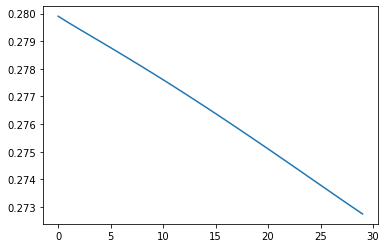

In [17]:
plt.plot(losses)

## Train and evaluate

Define a simple evaluation function. Don't forget to load the models back into main memory from cuda.

In [21]:
def eval_mod_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=4, num_classes=6):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, 5, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x,y,batch_first=True)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes)

            if mod_order == 2:
                corrects += torch.sum(y_hat.argmax(axis=2) < 2)
            elif mod_order == 4:
                corrects += torch.sum(sum([y_hat.argmax(axis=2) == val for val in [2,3,4,5]]))
            elif mod_order == 8:
                corrects += torch.sum(y_hat.argmax(axis=2) > 5)

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

In [22]:
def train_model(model_config, data_config, train_config, conv=False):
    
    train_dataloader = gen_dataset(data_config, train_config, conv_compatible=conv)
    
    ## bpsk
    x_bpsk, y_bpsk = gen_data(num_examples=data_config['num_examples_val'], 
                              seq_length=data_config['seq_length'], 
                              mod_order=2, 
                              sps=data_config['sps'], 
                              snr=data_config['snr_val'])
    

    x_val_bpsk, y_val_bpsk = to_tensors(x_bpsk, y_bpsk, batch_first=True, gpu=True, onehot=True, num_classes=6, conv_compatible=conv)
    
    val_dataloader_bpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_bpsk, y_val_bpsk), batch_size=train_config['batch_size'], shuffle=True)

    ## qpsk 
    x_qpsk, y_qpsk = gen_data(num_examples=data_config['num_examples_val'], 
                              seq_length=data_config['seq_length'], 
                              mod_order=4, 
                              sps=data_config['sps'], 
                              snr=data_config['snr_val'])
    y_qpsk += 2
    x_val_qpsk, y_val_qpsk = to_tensors(x_qpsk, y_qpsk, batch_first=True, gpu=True, onehot=True, num_classes=6, conv_compatible=conv)
    val_dataloader_qpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_qpsk, y_val_qpsk), batch_size=train_config['batch_size'], shuffle=True)

    # Loss function - MSE works best for some reason
#     criterion = nn.MSELoss()
    # criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()

    # Create the encoder and decoder models
    if conv:
        encoder = EncoderConvRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['input_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])
    else:
        encoder = EncoderRNN(hidden_size = model_config['hidden_size'], 
                             input_size = model_config['input_size'],
                             num_layers = model_config['num_layers'], 
                             device = train_config['device'])
    
    decoder = DecoderRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['output_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])

    encoder.cuda()
    decoder.cuda()
    
    # Initialize the optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])
    
    decoder_optimizer = optim.Adam(decoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])

    # Define empty lists where loss progress will be stored
    losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

    best_loss = np.inf

    # Training loop
    for _ in range(train_config['num_epochs']):
        train_loss = 0
        for x_train,y_train in train_dataloader:

            train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                     teacher_forcing=False, conv=conv)

        losses.append(train_loss/len(train_dataloader))
        
        with torch.no_grad():
            val_loss = 0
            for x_val,y_val in val_dataloader_bpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion, conv=conv)
            val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

            val_loss = 0
            for x_val,y_val in val_dataloader_qpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion, conv=conv)
            val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))
            
            val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
            val_losses.append(val_loss)

            if val_loss < best_loss:
                encoder_weights = encoder.state_dict()
                decoder_weights = decoder.state_dict()
                best_loss = val_losses[-1]
                

    
    results_dict = {'losses' : losses,
                    'val_losses' : val_losses,
                    'bpsk_losses' : val_losses_bpsk,
                    'qpsk_losses' : val_losses_qpsk,
                    'encoder_weights' : encoder_weights,
                    'decoder_weights' : decoder_weights}
    
    return results_dict

def test_model(encoder, decoder, test_config):
    
    bpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
    qpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)
    
    bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
    qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)
    
    results_dict = {'bpsk_accs': bpsk_accs,
                    'qpsk_accs': qpsk_accs,
                    'bpsk_class_accs': bpsk_class_accuracy,
                    'qpsk_class_accs': qpsk_class_accuracy}
    
    return results_dict

## Training for different sequence lengths

In [23]:
model_config = {'hidden_size': 64,
                'num_layers': 2,
                'input_size': 2,
                'output_size': 6}

data_config = {'snr': np.array([10]),#np.arange(-10,21,5), #np.array([0])
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256,
               'snr_val': 10}

train_config = {'num_epochs': 200,
                'batch_size': 32,
                'learning_rate': 0.001,
                'weight_decay': 0,
                'device': 'cuda',
                'teacher_forcing': False}

test_config = {'snr_range': np.arange(-30,30),
               'num_iter': 1024}

In [ ]:
train_config = {'num_epochs': 100,
                'batch_size': 64,
                'learning_rate': 3e-4,
                'weight_decay': 0.0001,
                'device': 'cuda',
                'teacher_forcing': False}

# 'snr': np.array([-10, -5, 0, 5, 10, 15])
data_config = {'snr': np.arange(-5,21,5),
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

In [150]:
seq_lengths = [5, 10, 15, 20]
hidden_sizes = [16, 128]
num_layers = [2] #3
num_models = 5
num_epochs = 250
snr = 10

In [151]:
for seq_length in seq_lengths:
    for num_layer in num_layers:
        for hidden_size in hidden_sizes:
            print(f'Training {seq_length}, {num_layer}, {hidden_size}')
            data_config['seq_length'] = seq_length
            model_config['hidden_size'] = hidden_size
            model_config['num_layers'] = num_layer
            train_config['num_epochs'] = num_epochs
            data_config['snr'] = np.array([snr])
            data_config['snr_val'] = snr

            all_train_results = []
            for i in range(num_models):
                print(i)
                torch.manual_seed(i)
                train_results = train_model(model_config, data_config, train_config, conv=False)
                all_train_results.append(train_results)
            torch.save(all_train_results, 
                       f"models/seq2seq_{num_layer}_{hidden_size}_seq_{seq_length}_{num_epochs}_epochs_snr_{snr}.pt")

Training 5, 2, 16
0
1
2
3
4
Training 5, 2, 128
0
1
2
3
4
Training 10, 2, 16
0
1
2
3
4
Training 10, 2, 128
0
1
2
3
4
Training 15, 2, 16
0
1
2
3
4
Training 15, 2, 128
0
1
2
3
4
Training 20, 2, 16
0
1
2
3
4
Training 20, 2, 128
0
1
2
3
4


In [152]:
model_config['input_size'] = 8

In [146]:
# num_layers = [2]
# hidden_sizes = [128]
# seq_lengths = [20]

In [153]:
for seq_length in seq_lengths:
    for num_layer in num_layers:
        for hidden_size in hidden_sizes:
            print(f'Training {seq_length}, {num_layer}, {hidden_size}')
            data_config['seq_length'] = seq_length
            model_config['hidden_size'] = hidden_size
            model_config['num_layers'] = num_layer
            train_config['num_epochs'] = num_epochs

            all_train_results = []
            for i in range(num_models):
                print(i)
                torch.manual_seed(i)
                train_results = train_model(model_config, data_config, train_config, conv=True)
                all_train_results.append(train_results)
            torch.save(all_train_results, 
                       f"models/seq2seq_conv_{num_layer}_{hidden_size}_seq_{seq_length}_{num_epochs}_epochs_snr_{snr}.pt")

Training 5, 2, 16
0
1
2
3
4
Training 5, 2, 128
0
1
2
3
4
Training 10, 2, 16
0
1
2
3
4
Training 10, 2, 128
0
1
2
3
4
Training 15, 2, 16
0
1
2
3
4
Training 15, 2, 128
0
1
2
3
4
Training 20, 2, 16
0
1
2
3
4
Training 20, 2, 128
0
1
2
3
4


## Evaluate all Seq2Seqs

In [90]:
def eval_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, 
                  sps=4, num_classes=6, batch_size=32, conv=False):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x, y, batch_first=True, conv_compatible=conv)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            if not conv:
                x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes, seq_length=seq_length)
#             print(y_hat.argmax(axis=2))

            corrects += torch.sum(y_hat.argmax(axis=2) == y.squeeze())

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return np.array(accuracies)

In [111]:
conv= True

num_layer = 2
seq_length = 20
hidden_size = 128

if conv:
    encoder = EncoderConvRNN(hidden_size = hidden_size, 
                     input_size = 8,
                     num_layers = num_layer, 
                     device = train_config['device'])
else:
    encoder = EncoderRNN(hidden_size = hidden_size, 
                         input_size = 2,
                         num_layers = num_layer, 
                         device = train_config['device'])

decoder = DecoderRNN(hidden_size = hidden_size, 
                     input_size = 6,
                     num_layers = num_layer, 
                     device = train_config['device'])


encoder.load_state_dict(torch.load(
    f"models/seq2seq_conv_{num_layer}_{hidden_size}_seq_{seq_length}_{num_epochs}_epochs.pt")[0]['encoder_weights'])
decoder.load_state_dict(torch.load(
    f"models/seq2seq_conv_{num_layer}_{hidden_size}_seq_{seq_length}_{num_epochs}_epochs.pt")[0]['decoder_weights'])

<All keys matched successfully>

In [114]:
accs_bpsk = eval_accuracy(encoder, decoder, np.arange(-30,31,5), seq_length=15, conv=True, mod_order=2, num_examples=128)
accs_qpsk = eval_accuracy(encoder, decoder, np.arange(-30,31,5), seq_length=15, conv=True, mod_order=4, num_examples=128)

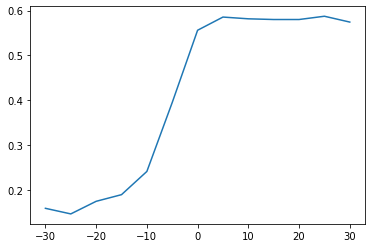

In [115]:
plt.plot(np.arange(-30,31,5), (accs_bpsk+accs_qpsk)/2)
# plt.plot(np.arange(-30,30,5), accs_qpsk)

## Training for different sequence lengths

In [33]:
model_config = {'hidden_size': 64,
                'num_layers': 2,
                'input_size': 2,
                'output_size': 6}

data_config = {'snr': np.array([0]),#np.arange(-10,21,5), #np.array([0])
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256,
               'snr_val': 5}

train_config = {'num_epochs': 100,
                'batch_size': 32,
                'learning_rate': 0.001,
                'weight_decay': 0,
                'device': 'cuda',
                'teacher_forcing': False}

test_config = {'snr_range': np.arange(-30,30),
               'num_iter': 1024}

In [34]:
seq_lengths = [5, 10, 15, 20]

In [35]:
for seq_length in seq_lengths:
    print(f'Training {seq_length}')
    data_config['seq_length'] = seq_length
    
    all_train_results = []
    for i in range(5):
        print(i)
        torch.manual_seed(i)
        train_results = train_model(model_config, data_config, train_config, conv=False)
        all_train_results.append(train_results)
    torch.save(all_train_results, f'models/seq2seq_hidden_64_seq_{seq_length}_100_epochs.pt')

Training 5
0
1
2
3
4
Training 10
0
1
2
3
4
Training 15
0
1
2
3
4
Training 20
0
1
2
3
4


In [36]:
model_config['input_size'] = 8

In [37]:
for seq_length in seq_lengths:
    print(f'Training {seq_length}')
    data_config['seq_length'] = seq_length
    
    all_train_results = []
    for i in range(5):
        print(i)
        torch.manual_seed(i)
        train_results = train_model(model_config, data_config, train_config, conv=True)
        all_train_results.append(train_results)
    torch.save(all_train_results, f'models/seq2seq_conv_hidden_64_seq_{seq_length}_100_epochs.pt')

Training 5
0
1
2
3
4
Training 10
0
1
2


KeyboardInterrupt: 

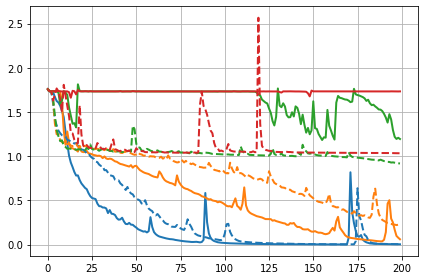

In [152]:
for i, seq_length in enumerate(seq_lengths):
#     plt.figure()
#     for result in torch.load(f"models/seq2seq_seq_{seq_length}_200_epochs.pt"):
#         plt.plot(result['losses'], f'C{i}')
    results = torch.load(f"models/seq2seq_hidden_64_seq_{seq_length}_200_epochs.pt")
    plt.plot(np.mean([result['losses'] for result in results],axis=0), f'C{i}', linewidth=2)


for i, seq_length in enumerate(seq_lengths):
#     plt.figure()
#     for result in torch.load(f"models/seq2seq_seq_{seq_length}_200_epochs.pt"):
#         plt.plot(result['losses'], f'C{i}')
    results = torch.load(f"models/seq2seq_conv_hidden_64_seq_{seq_length}_200_epochs.pt")
    plt.plot(np.mean([result['losses'] for result in results],axis=0), f'C{i}--', linewidth=2)
plt.grid()
plt.tight_layout()

## Deeper dive into conv arch

In [8]:
class EncoderConvRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu', num_filters=16):
        super(EncoderConvRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        self.conv1 = nn.Conv1d(2,num_filters,9, padding=4)
        self.conv2 = nn.Conv1d(num_filters,8,9)
        self.maxpool = nn.MaxPool1d(2)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = x.permute(0,2,1)
#         x = x.permute(2,0,1)
        
        output, hidden = self.rnn(x)
        
        return output, hidden

In [10]:
model_config = {'hidden_size': 64,
                'num_layers': 2,
                'input_size': 8,
                'output_size': 6}

data_config = {'snr': np.array([0]),#np.arange(-10,21,5), #np.array([0])
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256,
               'snr_val': 5}

train_config = {'num_epochs': 100,
                'batch_size': 32,
                'learning_rate': 0.001,
                'weight_decay': 0,
                'device': 'cuda',
                'teacher_forcing': False}

test_config = {'snr_range': np.arange(-30,30),
               'num_iter': 1024}

In [12]:
seq_lengths = [5, 10, 15, 20]

In [14]:
for seq_length in seq_lengths:
    print(f'Training {seq_length}')
    data_config['seq_length'] = seq_length
    
    all_train_results = []
    for i in range(5):
        print(i)
        torch.manual_seed(i)
        train_results = train_model(model_config, data_config, train_config, conv=True)
        all_train_results.append(train_results)
    torch.save(all_train_results, f'models/seq2seq_conv_hidden_64_seq_{seq_length}_100_epochs.pt')

Training 5
0
1
2
3
4
Training 10
0
1
2
3
4
Training 15
0
1
2
3
4
Training 20
0
1
2
3
4


In [49]:
train_results = train_model(model_config, data_config, train_config, conv=True)

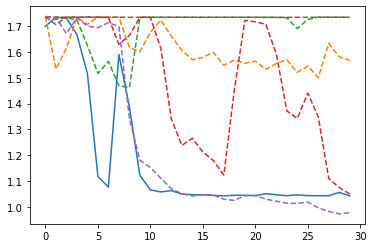

In [58]:
plt.plot(train_results['losses'])
results = torch.load(f"models/seq2seq_hidden_64_seq_20_100_epochs.pt")
for result in results:
    plt.plot(result['losses'][:30], '--')
# plt.plot(np.mean([result['losses'][:30] for result in results],axis=0), linewidth=2)

In [105]:
train_results_conv = train_model(model_config, data_config, train_config, conv=True)

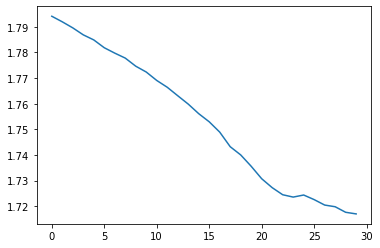

In [107]:
plt.plot(train_results_conv['losses'])

In [74]:
model_config['input_size'] = 2

In [75]:
train_results_rnn = train_model(model_config, data_config, train_config, conv=False)

RuntimeError: Expected hidden[0] size (2, 20, 256), got (2, 32, 256)

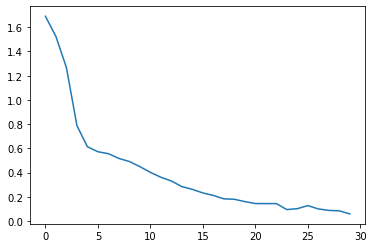

In [23]:
plt.plot(train_results_rnn['losses'])

In [57]:
seq_lengths = [5, 10, 15, 20]

In [60]:
all_all_losses = []
for i in range(5):
    
    all_losses = []
    for seq_length in seq_lengths:
        data_config['seq_length'] = seq_length

        train_results = train_model(model_config, data_config, train_config)

        all_losses.append(train_results['losses'])
    all_all_losses.append(all_losses)

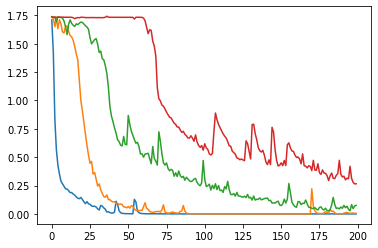

In [63]:
plt.plot(np.array(all_losses).T)

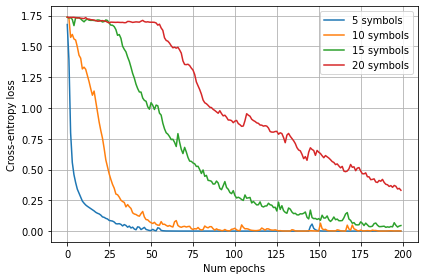

In [72]:
plt.plot(np.array(all_all_losses).mean(axis=0).T)
plt.xlabel('Num epochs'); plt.ylabel('Cross-entropy loss')
plt.legend(('5 symbols', '10 symbols', '15 symbols', '20 symbols'))
plt.grid()
plt.tight_layout()
plt.savefig('figures/losses_per_seq_length.png', dpi=300)

## Train on more snr data for better DT comparison

In [56]:
data_config['num_examples_bpsk'] = 1024
data_config['num_examples_qpsk'] = 1024
results_equal_dist = train_and_evaluate(model_config, data_config, train_config, test_config)

In [57]:
data_config['num_examples_bpsk'] = 1024
data_config['num_examples_qpsk'] = 2048
results_qpsk_bias = train_and_evaluate(model_config, data_config, train_config, test_config)

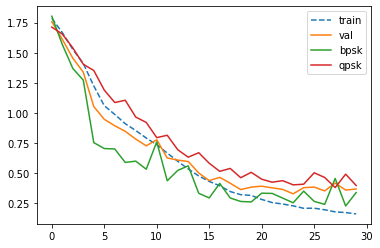

In [58]:
# plt.plot(results_equal_dist['losses'])
plt.plot(results_qpsk_bias['losses'], '--')
plt.plot(results_qpsk_bias['val_losses'])

# plt.plot(results_equal_dist['bpsk_losses'])
plt.plot(results_qpsk_bias['bpsk_losses'])

# plt.plot(results_equal_dist['qpsk_losses'])
plt.plot(results_qpsk_bias['qpsk_losses'])
plt.legend(('train', 'val', 'bpsk', 'qpsk'))

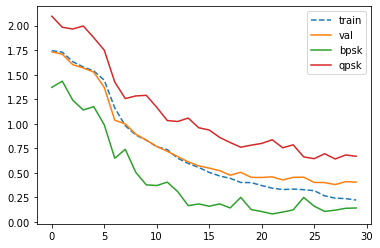

In [59]:
plt.plot(results_equal_dist['losses'], '--')
# plt.plot(results_qpsk_bias['losses'])
plt.plot(results_equal_dist['val_losses'])

plt.plot(results_equal_dist['bpsk_losses'])
# plt.plot(results_qpsk_bias['bpsk_losses'])

plt.plot(results_equal_dist['qpsk_losses'])
# plt.plot(results_qpsk_bias['qpsk_losses'])
plt.legend(('train', 'val', 'bpsk', 'qpsk'))

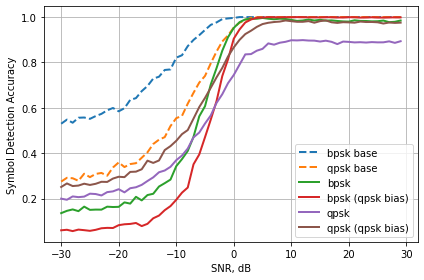

In [52]:
plt.plot(snr_range, bpsk_baseline, '--', linewidth=2)
plt.plot(snr_range, qpsk_baseline, '--', linewidth=2)
plt.plot(snr_range, results_equal_dist['bpsk_accs'], linewidth=2)
plt.plot(snr_range, results_qpsk_bias['bpsk_accs'], linewidth=2)
plt.plot(snr_range, results_equal_dist['qpsk_accs'], linewidth=2)
plt.plot(snr_range, results_qpsk_bias['qpsk_accs'], linewidth=2)
plt.legend(('bpsk base', 'qpsk base', 'bpsk', 'bpsk (qpsk bias)', 'qpsk', 'qpsk (qpsk bias)'))
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Symbol Detection Accuracy')
plt.tight_layout()

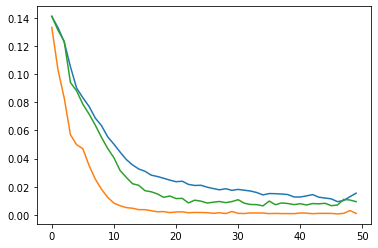

In [51]:
# plt.plot(results_equal_dist['losses'])
plt.plot(results_qpsk_bias['losses'])

# plt.plot(results_equal_dist['bpsk_losses'])
plt.plot(results_qpsk_bias['bpsk_losses'])

# plt.plot(results_equal_dist['qpsk_losses'])
plt.plot(results_qpsk_bias['qpsk_losses'])

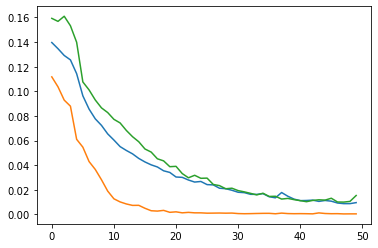

In [52]:
plt.plot(results_equal_dist['losses'])
# plt.plot(results_qpsk_bias['losses'])

plt.plot(results_equal_dist['bpsk_losses'])
# plt.plot(results_qpsk_bias['bpsk_losses'])

plt.plot(results_equal_dist['qpsk_losses'])
# plt.plot(results_qpsk_bias['qpsk_losses'])

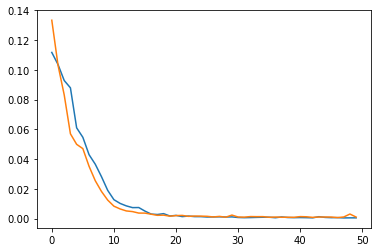

In [41]:
plt.plot(results_equal_dist['bpsk_losses'])
plt.plot(results_qpsk_bias['bpsk_losses'])

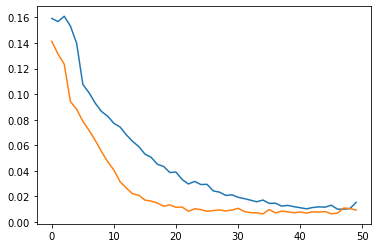

In [42]:
plt.plot(results_equal_dist['qpsk_losses'])
plt.plot(results_qpsk_bias['qpsk_losses'])

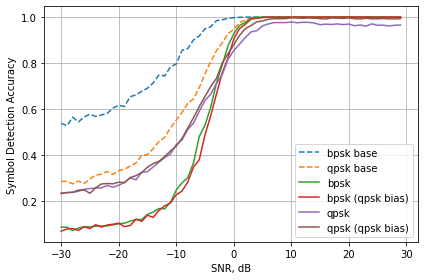

In [34]:
plt.plot(snr_range, bpsk_baseline, '--')
plt.plot(snr_range, qpsk_baseline, '--')
plt.plot(snr_range, results_equal_dist['bpsk_accs'])
plt.plot(snr_range, results_qpsk_bias['bpsk_accs'])
plt.plot(snr_range, results_equal_dist['qpsk_accs'])
plt.plot(snr_range, results_qpsk_bias['qpsk_accs'])
plt.legend(('bpsk base', 'qpsk base', 'bpsk', 'bpsk (qpsk bias)', 'qpsk', 'qpsk (qpsk bias)'))
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Symbol Detection Accuracy')
plt.tight_layout()

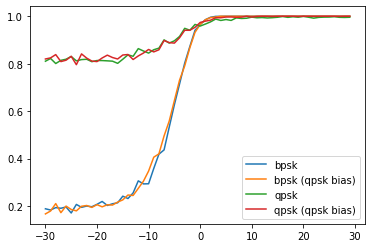

In [87]:
plt.plot(snr_range, results_equal_dist['bpsk_class_accs'])
plt.plot(snr_range, results_qpsk_bias['bpsk_class_accs'])
plt.plot(snr_range, results_equal_dist['qpsk_class_accs'])
plt.plot(snr_range, results_qpsk_bias['qpsk_class_accs'])
plt.legend(('bpsk', 'bpsk (qpsk bias)', 'qpsk', 'qpsk (qpsk bias)'))

In [44]:
def train_model(model_config, data_config, train_config):
    
    x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'], 
                              data_config['seq_length'], 
                              mod_order=2, sps=data_config['sps'], 
                              snr=data_config['snr'])
    
    x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'], 
                              data_config['seq_length'], 
                              mod_order=4, sps=data_config['sps'], 
                              snr=data_config['snr'])
    y_qpsk += 2
    x = np.concatenate((x_bpsk, x_qpsk))
    y = np.concatenate((y_bpsk, y_qpsk))

    x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True)

    train_dataset = torch.utils.data.TensorDataset(x, y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)


    # Loss function - MSE works best for some reason
    criterion = nn.MSELoss()
    # criterion = nn.NLLLoss()
    # criterion = nn.CrossEntropyLoss()

    # Create the encoder and decoder models
    encoder = EncoderRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['input_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])
    
    decoder = DecoderRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['output_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])

    # Initialize the optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])
    
    decoder_optimizer = optim.Adam(decoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])

    # Define empty lists where loss progress will be stored
    losses, val_losses_bpsk, val_losses_qpsk = [], [], []

    best_loss = np.inf

    # Training loop
    for _ in range(train_config['num_epochs']):
        train_loss = 0
        for x_train,y_train in train_dataloader:

            train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                     teacher_forcing=False, gpu=gpu)

        losses.append(train_loss/len(train_dataloader))

        with torch.no_grad():
            val_loss = 0
            for x_val,y_val in val_dataloader_bpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
            val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

            val_loss = 0
            for x_val,y_val in val_dataloader_qpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
            val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

    losses_dict = {'losses' : losses,
                    'bpsk_losses' : val_losses_bpsk,
                    'qpsk_losses' : val_losses_qpsk}
    
    return encoder, decoder, losses_dict

In [45]:
encoder, decoder, losses_dict = train_model(model_config, data_config, train_config)

In [ ]:
def eval_seq_lengths(encoder, decoder, snr_range, seq_lengths):
        encoder.cpu()
        decoder.cpu()

        for length in seq_lengths:
            
            bpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
            qpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)

#             bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
#             qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)

        
        
        results_dict = {'losses' : losses,
                        'bpsk_losses' : val_losses_bpsk,
                        'qpsk_losses' : val_losses_qpsk,
                        'bpsk_accs': bpsk_accs,
                        'qpsk_accs': qpsk_accs,
                        'bpsk_class_accs': bpsk_class_accuracy,
                        'qpsk_class_accs': qpsk_class_accuracy}

In [ ]:
seq_lengths = np.arange(5,50,5)

qpsk_class_accs = []

for length in seq_lengths:
    accuracies_qpsk = []

    for snr in snr_range:
        x_test, y_test = gen_mod_data(512, length, mod_order=4, sps=4, span=10, snr=snr)

        num_correct = 0

        for idx, x in enumerate(x_test):
            y_hat = classify_demodulate(x)
            num_correct += np.sum(y_hat==y_test[idx])

        accuracies_qpsk.append(num_correct/y_test.size)
    qpsk_class_accs.append(np.mean(accuracies_qpsk))